In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023-2024
# see embedded licence file

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

# local imports
import gpvisc

# import sklearn utils
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

import joblib

# CPU or GPU?
device = gpvisc.get_device()

Will run on cuda


## Loading and models

In [2]:
# Data loading
print("Loading the viscosity datasets...")
ds = gpvisc.data_loader()

# Add scalers
ds.scaler_tpx = StandardScaler().fit(ds.TPX_train_valid[:,:14]) # for the blackbox model

print("Loading the models...")
#Linear Regression
clf_linreg = joblib.load('./models/clf_linreg.joblib')

# Support Vector Machine regression
clf_svr = joblib.load('./models/clf_svr.joblib')

# Artificial Neural Network
clf_nn = joblib.load('./models/clf_nn.joblib')

# Random Forest Regressor
clf_rf = joblib.load('./models/clf_rf.joblib')
   
# gaussian process ANN model
gp_model, likelihood = gpvisc.load_gp_model(model_number=1, device=device)
print('Loaded.')

Loading the viscosity datasets...
Loading the models...


/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from ver

Loaded.


In [3]:
def predict_one_compo(di_, # subset
                      ds, # data object
                      T_interest,
                      P_interest):

    # check composition
    di_ = gpvisc.chimie_control(di_).copy()
    
    # add descriptors
    #xi_ = gpvisc.descriptors(di_.loc[:, gpvisc.list_oxides()])

    # same composition so we get first line, then create an array with interesting temps
    #xi = np.ones((len(T_interest),xi_.shape[1]))*xi_.values[0,:]

    # transformation
    tpxi_scaled = gpvisc.scale_for_blackbox(T_interest, 
                                            P_interest, 
                                            di_.loc[[0],gpvisc.list_oxides()], 
                                            ds.scaler_tpx)
    
    tpx_for_gp = gpvisc.scale_for_gaussianprocess(T_interest, 
                                                 P_interest,
                                                 di_.loc[[0],:])
    
    # predictions 
    oneC_lin = clf_linreg.predict(tpxi_scaled)
    oneC_svr = clf_svr.predict(tpxi_scaled)
    oneC_nn = clf_nn.predict(tpxi_scaled)
    oneC_rf = clf_rf.predict(tpxi_scaled)
    oneC_grey = gpvisc.predict(tpx_for_gp, gp_model, likelihood, model_to_use="ann", device=device) 
    y_gp_mean, y_gp_std = gpvisc.predict(tpx_for_gp, gp_model, likelihood, model_to_use="gp", device=device) 
    oneC_gp = [y_gp_mean, y_gp_mean-y_gp_std, y_gp_mean+y_gp_std]
    
    predictions = (oneC_lin, oneC_svr, oneC_rf, oneC_nn, oneC_grey, oneC_gp)
    return predictions

dataset_peridotite = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="peridotite",:].reset_index()
dataset_casio3 = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="casio3",:].reset_index()
dataset_mgsio3 = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="mgsio3",:].reset_index()
dataset_albite = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="albite",:].reset_index()


In [4]:
predictions_albite = predict_one_compo(dataset_albite, ds, dataset_albite["T"].values, dataset_albite["P"].values)
predictions_casio3 = predict_one_compo(dataset_casio3, ds, dataset_casio3["T"].values, dataset_casio3["P"].values)
predictions_mgsio3 = predict_one_compo(dataset_mgsio3, ds, dataset_mgsio3["T"].values, dataset_mgsio3["P"].values)
predictions_peridotite = predict_one_compo(dataset_peridotite, ds, dataset_peridotite["T"].values, dataset_peridotite["P"].values)

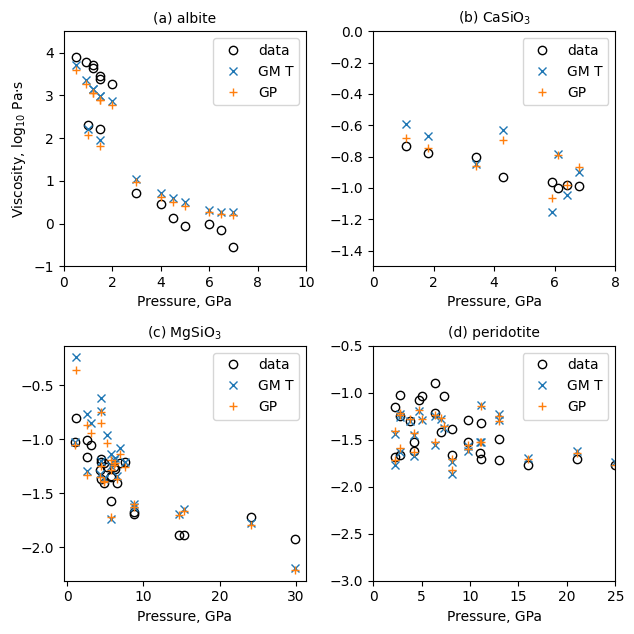

In [5]:
plt.figure(figsize=(6.44,6.44))
plt.subplot(2,2,1)
plt.title("(a) albite", fontsize=10)
plt.plot(dataset_albite.loc[:,"P"],dataset_albite.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_albite.loc[:,"P"],
         predictions_albite[4],"x", alpha=1., linestyle="", label="GM T")
plt.plot(dataset_albite.loc[:,"P"],
         predictions_albite[5][0],"+", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")
plt.ylim(-1,4.5)
plt.xlim(0,10)
plt.legend()

plt.subplot(2,2,2)
plt.title("(b) CaSiO$_3$", fontsize=10)
plt.plot(dataset_casio3.loc[:,"P"],dataset_casio3.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_casio3.loc[:,"P"],
         predictions_casio3[4],"x", alpha=1., linestyle="", label="GM T")
plt.plot(dataset_casio3.loc[:,"P"],
         predictions_casio3[5][0],"+", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylim(-1.5,0)
plt.xlim(0,8)
plt.legend()

plt.subplot(2,2,3)
plt.title("(c) MgSiO$_3$", fontsize=10)
plt.plot(dataset_mgsio3.loc[:,"P"],dataset_mgsio3.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_mgsio3.loc[:,"P"],
         predictions_mgsio3[4],"x", alpha=1., linestyle="", label="GM T")
plt.plot(dataset_mgsio3.loc[:,"P"],
         predictions_mgsio3[5][0],"+", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.legend()

plt.subplot(2,2,4)
plt.title("(d) peridotite", fontsize=10)
plt.plot(dataset_peridotite.loc[:,"P"],dataset_peridotite.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_peridotite.loc[:,"P"],
         predictions_peridotite[4],"x", alpha=1., linestyle="", label="GM T")
plt.plot(dataset_peridotite.loc[:,"P"],
         predictions_peridotite[5][0],"+", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylim(-3.0,-0.5)
plt.xlim(0,25)
plt.legend()

plt.tight_layout()

## Error comparison

RMSE on the entire high pressure dataset are:
for the greybox model: 0.63
for the Gaussian process model: 0.58


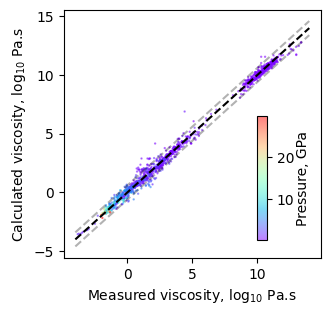

In [6]:
# reading the Pandas dataframe
dataset_hp_ = gpvisc.chimie_control(ds.dataset_hp.sort_values(by="P").copy())

# prepare data
X_hp = gpvisc.scale_for_gaussianprocess(dataset_hp_["T"], dataset_hp_["P"], dataset_hp_)

# predict with the two models
oneC_greyhp = gpvisc.predict(X_hp, gp_model, likelihood, model_to_use="ann", device=device)
oneC_gp, oneC_gp_std = gpvisc.predict(X_hp, gp_model, likelihood, model_to_use="gp", device=device)

fig = plt.figure(figsize=(3.32,3.22))
ax = plt.subplot()
plt.plot([-4,14],[-4,14],'k--')
plt.plot([-4,14],[-4+0.6,14+0.6],'k--',alpha=0.3)
plt.plot([-4,14],[-4-0.6,14-0.6],'k--',alpha=0.3)
pcm = plt.scatter(dataset_hp_.loc[:,'viscosity'].values.reshape(-1,1),
            oneC_gp,
            cmap='rainbow',
            c=dataset_hp_.loc[:,"P"].values.reshape(-1,1),
            marker='.',
            s=2,
            alpha = 0.5
           )
plt.xlabel('Measured viscosity, log$_{10}$ Pa.s')
plt.ylabel('Calculated viscosity, log$_{10}$ Pa.s')
# manual placing of the colorbar
cax = ax.inset_axes([0.75, 0.07, 0.04, 0.5])
cbar = fig.colorbar(pcm,
             cax=cax, orientation='vertical',
             ticks=[0,10,20,30])
cbar.set_label('Pressure, GPa', labelpad=1)

#plt.colorbar(label='Pressure, GPa', anchor=(0.1,0.1))
#plt.tight_layout()
plt.savefig("./figures/pred_vs_meas_HP.pdf")

print("RMSE on the entire high pressure dataset are:")
print("for the greybox model: {:.2f}".format(np.sqrt(root_mean_squared_error(dataset_hp_.loc[:,'viscosity'].values, oneC_greyhp))))
print("for the Gaussian process model: {:.2f}".format(np.sqrt(root_mean_squared_error(dataset_hp_.loc[:,'viscosity'].values, oneC_gp))))

# Final figure for paper

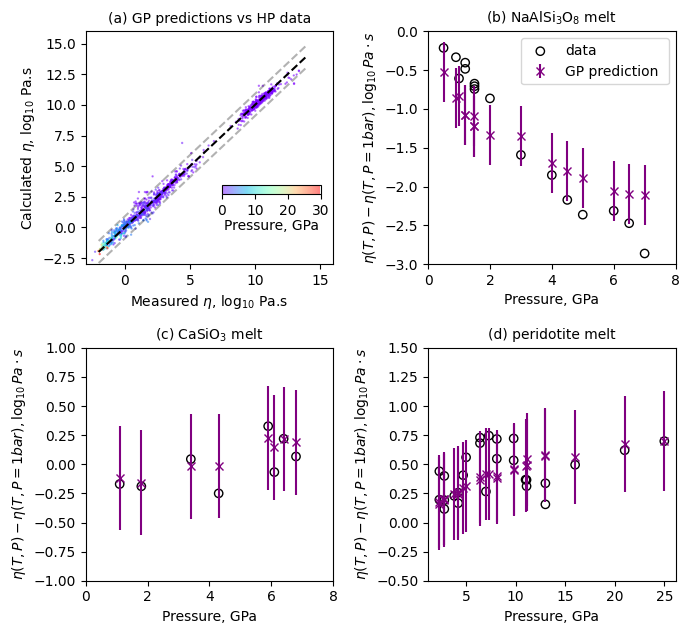

In [7]:
fig = plt.figure(figsize=(7.0,6.44))
ax_hpcomp = plt.subplot(2,2,1)
plt.title("(a) GP predictions vs HP data", fontsize=10)
plt.plot([-2,14],[-2,14],'k--',label="1:1")
plt.plot([-2,14],[-2.9,13.1],'k--',alpha=0.3)
plt.plot([-2,14],[-1.1,14.9],'k--',alpha=0.3)
pcm=plt.scatter(dataset_hp_.loc[:,'viscosity'].values.reshape(-1,1),
            oneC_gp,
            cmap='rainbow',
            c=dataset_hp_.loc[:,"P"].values.reshape(-1,1),
            marker='.',
            s=2,
            alpha = 0.5
           )
plt.xlabel('Measured $\eta$, log$_{10}$ Pa.s')
plt.ylabel('Calculated $\eta$, log$_{10}$ Pa.s')
cax = ax_hpcomp.inset_axes([0.55, 0.3, 0.4, 0.04])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal')
cbar.set_label('Pressure, GPa', labelpad=0.5)
cbar.set_ticks([0,10,20,30], labels=['0','10','20','30'])
plt.xlim(-3,16)
plt.ylim(-3,16)

ax_ab = plt.subplot(2,2,2)
plt.title("(b) NaAlSi$_3$O$_8$ melt", fontsize=10)
plt.scatter(dataset_albite.loc[:,"P"],
            dataset_albite.viscosity - (-4.5+10601/(dataset_albite.loc[:,"T"]-443.7)),  # TVF on LL2013 data
            marker='o',
            facecolor="None",
            edgecolor="k",
            label="data")
plt.errorbar(dataset_albite.loc[:,"P"],
             predictions_albite[5][0] - (-4.5+10601/(dataset_albite.loc[:,"T"]-443.7)),  # TVF on LL2013 data
             yerr = predictions_albite[5][0]-predictions_albite[5][1],
             c="purple",
             marker='x',
             linestyle="none",
             label="GP prediction ")
plt.xlabel("Pressure, GPa")
plt.ylabel("$\eta(T,P) - \eta(T,P=1bar), \log_{10} Pa\cdot s$")
plt.legend(fontsize=10)
plt.xlim(0,8)
plt.ylim(-3,0)

ax_casio3 = plt.subplot(2,2,3)
plt.title("(c) CaSiO$_3$ melt", fontsize=10)
plt.scatter(dataset_casio3.loc[:,"P"],
            dataset_casio3.viscosity - (-3.84+3454.4/(dataset_casio3.loc[:,"T"]-819.8)),  # TVF on Urbain data at 1 bar
            marker='o',
            facecolor="None",
            edgecolor="k",
            label="data")
plt.errorbar(dataset_casio3.loc[:,"P"],
             predictions_casio3[5][0]- (-3.84+3454.4/(dataset_casio3.loc[:,"T"]-819.8)), 
             yerr = predictions_casio3[5][0]-predictions_casio3[5][1],
             c="purple",
             marker='x',
             linestyle="none",
             label="GP predictions")
plt.xlabel("Pressure, GPa")
plt.ylabel("$\eta(T,P) - \eta(T,P=1bar), \log_{10} Pa\cdot s$")
plt.xlim(0,8)
plt.ylim(-1.0,1.0)

ax_pr = plt.subplot(2,2,4)
plt.title("(d) peridotite melt", fontsize=10)
plt.scatter(dataset_peridotite.loc[:,"P"],
            dataset_peridotite.viscosity - (-4.31+3703./(dataset_peridotite.loc[:,"T"]-761.7)), # TVF from Dingwell et al. 2004
            marker='o',
            facecolor="None",
            edgecolor="k",
            label="data")
plt.errorbar(dataset_peridotite.loc[:,"P"],
             predictions_peridotite[5][0]- (-4.31+3703./(dataset_peridotite.loc[:,"T"]-761.7)), # TVF from Dingwell et al. 2004
             yerr = predictions_peridotite[5][0]-predictions_peridotite[5][1],
             c="purple",
             marker='x',
             linestyle="none",
             label="GP prediction ")
plt.xlabel("Pressure, GPa")
plt.ylabel("$\eta(T,P) - \eta(T,P=1bar), \log_{10} Pa\cdot s$")
plt.ylim(-0.5,1.5)

###
# Arrange the axes
###
def arrange_axes(ax):
    # Move left y-axis and bottom x-axis to centre, passing through (0,0)
    #ax.spines['left'].set_position('center')
    #ax.spines['bottom'].set_position('center')
    
    # Eliminate upper and right axes
    #ax.spines['right'].set_color('none')
    #ax.spines['top'].set_color('none')
    
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

plt.tight_layout()
#plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig("./figures/Figure3.pdf")

### For presentations

In [8]:
# load other models
gp_model, likelihood = gpvisc.load_gp_model(model_number=1, device=device)
gp_model2, likelihood2 = gpvisc.load_gp_model(model_number=2, device=device)
gp_model3, likelihood3 = gpvisc.load_gp_model(model_number=3, device=device)

In [9]:
X_peridotite = gpvisc.generate_query_single(sio2=dataset_peridotite.loc[0, "sio2"],
                                     tio2=dataset_peridotite.loc[0, "tio2"],
                                     al2o3=dataset_peridotite.loc[0, "al2o3"],
                                     feo=dataset_peridotite.loc[0, "fe2o3"],
                                     mno=dataset_peridotite.loc[0, "mno"],
                                     na2o=dataset_peridotite.loc[0, "na2o"],
                                     k2o=dataset_peridotite.loc[0, "k2o"],
                                     mgo=dataset_peridotite.loc[0, "mgo"],
                                     cao=dataset_peridotite.loc[0, "cao"],
                                     p2o5=dataset_peridotite.loc[0, "p2o5"],
                                     h2o=dataset_peridotite.loc[0, "h2o"],
                                     composition_mole = True,
                                     T_init = 3000.0, T_final= 3000.0,
                                     P_init = 0.0, P_final = 100.0,
                                     control_redox = False,
                                     #fo2_init = np.log10(0.21), fo2_final = np.log10(0.21),
                                     nb_values = 200,
                                     )

TPX_peridotite = gpvisc.scale_for_gaussianprocess(X_peridotite["T"], X_peridotite["P"], X_peridotite)

# regroup models in lists
gp_models = [gp_model, gp_model2, gp_model3]
likelihoods = [likelihood, likelihood2, likelihood3]

results_mean, results_std = [], []
for i in range(1,4):
    mean_3000, std_3000 = gpvisc.predict(TPX_peridotite, gp_models[i-1], likelihoods[i-1], model_to_use="gp", device=device)
    results_mean.append(mean_3000)
    results_std.append(std_3000)

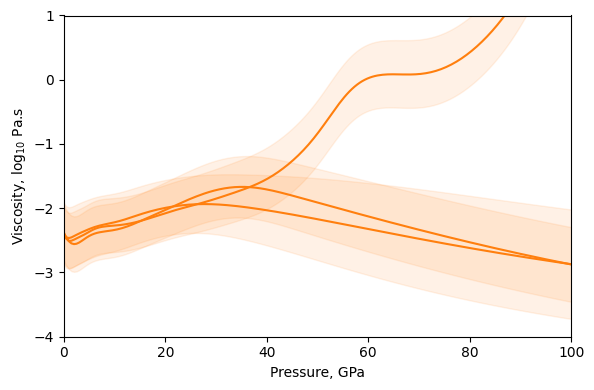

In [10]:
P_ = X_peridotite["P"].values

# gaussian process ANN model
fig = plt.figure(figsize=(6,4))
ax = plt.subplot()

for i in range(3):

    ax.plot(P_, results_mean[i], color="C1")
    ax.fill_between(P_, 
                 results_mean[i].ravel() - results_std[i].ravel(),
                 results_mean[i].ravel() + results_std[i].ravel(), alpha=0.1, color="C1")
    
ax.set_xlim(0,30)
ax.set_ylim(-4,1)

ax.set_xlabel("Pressure, GPa")
ax.set_ylabel('Viscosity, log$_{10}$ Pa.s')
plt.tight_layout()
plt.savefig("./figures/extrapolation_1.pdf")

ax.set_xlim(0,100)
plt.savefig("./figures/extrapolation_2.pdf")

In [11]:
# predict as a function of composition
oxide_ranges = {
    'sio2': [100., 0.0],
    'tio2': [0.0, 0.0],
    'al2o3': [0.0, 0.0],
    "feo" :[0.0, 0.0],
    "fe2o3":[0.0,0.0],
    "mno" :[0.0,0.0],
    "na2o":[0.0, 100.],
    "k2o" :[0.0, 0.0],
    "mgo" :[0.0, 0.0],
    "cao" :[0.0, 0.0],
    "p2o5":[0.0, 0.0],
    "h2o" :[0.0, 0.0],
}

Inputs_range = gpvisc.generate_query_range(oxide_ranges, composition_mole=True,
                                    T_init=1400, T_final=1400, P_init=0.0, P_final=0.0,
                                    nb_values=200)

# transformation
ptxi_scaled = gpvisc.scale_for_gaussianprocess(Inputs_range["T"], 
                                               Inputs_range["P"], 
                                               Inputs_range[gpvisc.list_oxides()])

# predictions
NS_1_mean, NS_1_std = gpvisc.predict(ptxi_scaled, gp_model=gp_model, likelihood=likelihood, device=device)
NS_2_mean, NS_2_std = gpvisc.predict(ptxi_scaled, gp_model=gp_model2, likelihood=likelihood2, device=device)
NS_3_mean, NS_3_std = gpvisc.predict(ptxi_scaled, gp_model=gp_model3, likelihood=likelihood3, device=device)


### Figure for paper

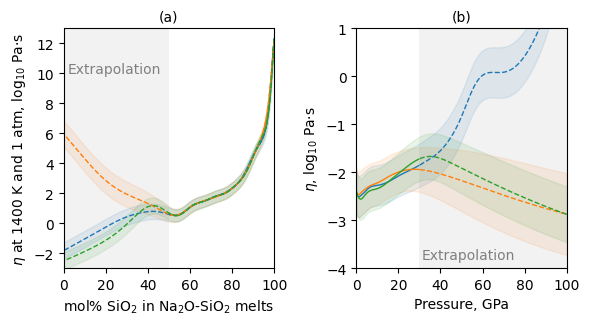

In [12]:
# gaussian process ANN model
fig = plt.figure(figsize=(6,3.22))
ax = plt.subplot(1,2,2)

colors = ["C0", "C1", "C2"]

for i in range(3):

    ax.plot(P_[P_<30], results_mean[i][P_<30], 
            linewidth=1.0, color=colors[i])
    ax.plot(P_[P_>=30], results_mean[i][P_>=30], 
            linestyle="--", linewidth=1.0, color=colors[i])
    ax.fill_between(P_, 
                 results_mean[i].ravel() - results_std[i].ravel(),
                 results_mean[i].ravel() + results_std[i].ravel(), alpha=0.1, color=colors[i])
    

plt.fill_betweenx([-4,1],[30,],[100,],color="grey",alpha=0.1, edgecolor="None")
plt.annotate("Extrapolation", xy=(31,-3.8),color="grey")

ax.set_xlabel("Pressure, GPa")
ax.set_ylabel('$\eta$, log$_{10}$ Pa$\cdot$s')

ax.set_xlim(0,100)
ax.set_ylim(-4,1)

ax2 = plt.subplot(1,2,1)
plt.plot(Inputs_range.loc[Inputs_range["sio2"]>0.5, "sio2"]*100, 
         NS_1_mean[Inputs_range["sio2"]>0.5],
         linewidth=1.0, linestyle="-",
         color="C0", label="Model 1")
plt.plot(Inputs_range.loc[Inputs_range["sio2"]>0.5, "sio2"]*100, 
         NS_2_mean[Inputs_range["sio2"]>0.5],
         linewidth=1.0, linestyle="-",
         color="C1", label="Model 2")
plt.plot(Inputs_range.loc[Inputs_range["sio2"]>0.5, "sio2"]*100, 
         NS_3_mean[Inputs_range["sio2"]>0.5],
         linewidth=1.0, linestyle="-",
        color="C2", label="Model 3")
plt.plot(Inputs_range["sio2"]*100, NS_1_mean,
         "--", linewidth=1.0, 
         color="C0", label="Model 1")
plt.plot(Inputs_range["sio2"]*100, NS_2_mean,
         "--", linewidth=1.0, 
         color="C1", label="Model 2")
plt.plot(Inputs_range["sio2"]*100, NS_3_mean,
         "--", linewidth=1.0, 
         color="C2", label="Model 3")
plt.fill_between(Inputs_range["sio2"]*100, 
                 NS_1_mean - NS_1_std,
                 NS_1_mean + NS_1_std,
                 alpha=0.1, color="C0")

plt.fill_between(Inputs_range["sio2"]*100, 
                 NS_2_mean - NS_2_std,
                 NS_2_mean + NS_2_std,
                 alpha=0.1, color="C1")

plt.fill_between(Inputs_range["sio2"]*100, 
                 NS_3_mean - NS_3_std,
                 NS_3_mean + NS_3_std,
                 alpha=0.1, color="C2")

plt.xlabel("mol% SiO$_2$ in Na$_2$O-SiO$_2$ melts")
plt.ylabel("$\eta$ at 1400 K and 1 atm, log$_{10}$ Pa$\cdot$s")

plt.fill_betweenx([-3.,13.],[0.,],[50.0,],color="grey", alpha=0.1, edgecolor="None")
plt.annotate("Extrapolation", xy=(2.0,10.0),color="grey")

ax2.set_xlim(0,100)
ax2.set_ylim(-3.,13.0)

plt.tight_layout()

ax.set_title("(b)", fontsize=10)
ax2.set_title("(a)", fontsize=10)

plt.savefig("./figures/extrapolation_paper.pdf")